[Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning](https://arxiv.org/abs/1506.02142)

Monte Carlo Dropout on classification of MedMNIST.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import medmnist
from medmnist import INFO, Evaluator
import torch.utils.data as data
import matplotlib.pyplot as plt
from tqdm.auto import tqdm, trange
import numpy as np

from torchmetrics.functional.classification import multiclass_calibration_error

data_flag = 'pathmnist'
download = True
info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

transform = transforms.Compose([transforms.ToTensor()])
train_set = DataClass(split='train', transform=transform, download=download)
test_set = DataClass(split='test', transform=transform, download=download)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


Using downloaded and verified file: /Users/chen/.medmnist/pathmnist.npz
Using downloaded and verified file: /Users/chen/.medmnist/pathmnist.npz


In [2]:
class MC_Dropout_CNN(nn.Module):
    def __init__(self, num_classes, dropout_rate):
        super(MC_Dropout_CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(32 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [3]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def test(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images, labels = images.to(device), labels.to(device).squeeze()

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return running_loss / len(dataloader), 100 * correct / total


In [4]:
device = torch.device("mps" if torch.has_mps else "cuda" if torch.cuda.is_available() else "cpu")

model = MC_Dropout_CNN(num_classes=n_classes, dropout_rate=0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [5]:
num_epochs = 3

for epoch in trange(1, num_epochs + 1):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    test_loss, accuracy = test(model, test_loader, criterion, device)
    print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}")


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [1/3], Train Loss: 1.1894, Test Loss: 1.1306, Accuracy: 63.8719


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [2/3], Train Loss: 0.9443, Test Loss: 0.9719, Accuracy: 73.4262


  0%|          | 0/2813 [00:00<?, ?it/s]

  0%|          | 0/225 [00:00<?, ?it/s]

Epoch [3/3], Train Loss: 0.8589, Test Loss: 1.0254, Accuracy: 76.0167


In [6]:
# Update the mc_dropout_prediction function to return probabilities
def mc_dropout_prediction(model, dataloader, device, num_samples=100):
    model.train()
    preds = []
    targets = []
    uncertainty = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device).squeeze()
            output_list = []

            for _ in range(num_samples):
                outputs = model(images)
                output_list.append(torch.softmax(outputs, dim=1).cpu().numpy())  # Get probabilities

            mean_output = np.mean(output_list, axis=0)
            std_output = np.std(output_list, axis=0)
            preds.extend(mean_output)
            targets.extend(labels.cpu().numpy())
            uncertainty.extend(std_output)
    
    preds = np.array(preds)
    targets = np.array(targets)
    uncertainty = np.array(uncertainty)

    return preds, targets, uncertainty

# Compute the predictions, targets, and uncertainty
preds, targets, uncertainty = mc_dropout_prediction(model, test_loader, device, num_samples=100)

# Compute the ECE
probs = torch.tensor(preds)
true_labels = torch.tensor(targets, dtype=torch.long)
ece = multiclass_calibration_error(probs, true_labels, num_classes=n_classes)
print(f"ECE: {ece:.4f}")


ECE: 0.1233


In [7]:
mc_accuracy = np.mean(np.argmax(preds, axis=1) == targets)
print(f"Monte Carlo dropout accuracy: {mc_accuracy:.4f}")
print(f"Uncertainty example: {uncertainty[:10]}")


Monte Carlo dropout accuracy: 0.7553
Uncertainty example: [[1.23327391e-05 3.65698914e-04 1.60096198e-01 6.75790245e-04
  2.22703069e-02 1.33374962e-03 1.41283810e-01 9.59724188e-03
  1.22278921e-01]
 [3.99950985e-03 1.20900692e-02 1.06425975e-02 2.19248869e-02
  1.37053430e-01 7.07032531e-03 8.01488385e-02 1.85850300e-02
  6.61972761e-02]
 [8.08886364e-02 1.20018378e-01 6.18181331e-03 3.17417493e-04
  1.19137108e-01 5.79563249e-03 5.37842661e-02 3.09973955e-03
  3.13176191e-03]
 [2.31006081e-04 4.11558489e-07 8.57004747e-02 3.32190879e-02
  3.99591029e-03 8.28005094e-03 1.37308106e-01 1.57185961e-02
  9.60758775e-02]
 [1.16519041e-01 2.75739953e-02 6.33915737e-02 1.87053811e-03
  1.30672008e-01 3.55334543e-02 1.26754910e-01 1.50035799e-03
  5.63062057e-02]
 [6.06293157e-02 2.19191417e-01 3.19847860e-03 2.98667885e-02
  1.82154387e-01 1.24944898e-04 5.68722039e-02 6.78109704e-04
  1.02973636e-02]
 [1.57225499e-04 2.03630468e-03 2.73130834e-02 5.07417228e-03
  3.98552753e-02 5.38560795e

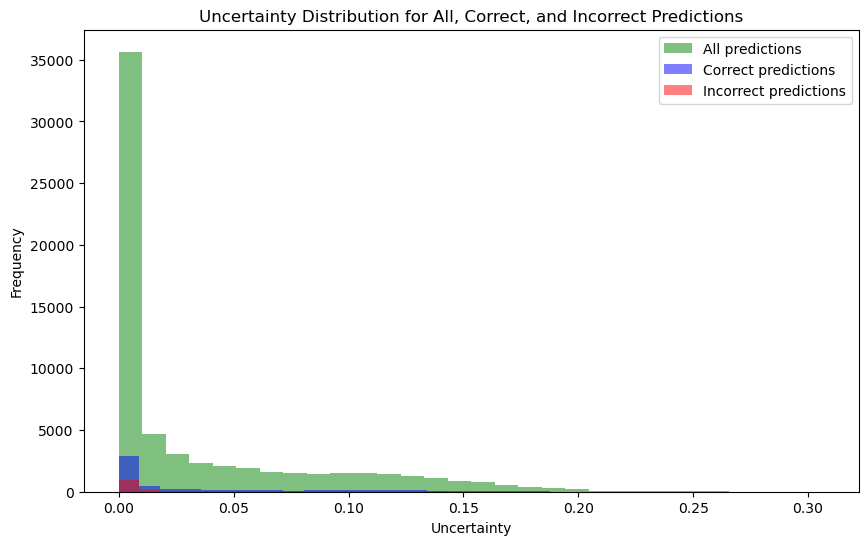

In [8]:
uncertainty = uncertainty.reshape(-1)

correct_indices = np.where(np.argmax(preds, axis=1) == targets)[0]
incorrect_indices = np.where(np.argmax(preds, axis=1) != targets)[0]

correct_uncertainties = uncertainty[correct_indices]
incorrect_uncertainties = uncertainty[incorrect_indices]

plt.figure(figsize=(10, 6))
plt.hist(uncertainty, bins=30, alpha=0.5, label="All predictions", color='green')
plt.hist(correct_uncertainties, bins=30, alpha=0.5, label="Correct predictions", color='blue')
plt.hist(incorrect_uncertainties, bins=30, alpha=0.5, label="Incorrect predictions", color='red')
plt.xlabel("Uncertainty")
plt.ylabel("Frequency")
plt.legend()
plt.title("Uncertainty Distribution for All, Correct, and Incorrect Predictions")
plt.show()
